In [1]:
import requests
import json
import os
import pandas as pd
import numpy as np

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

In [212]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (17.,6.)})
sns.set_style("whitegrid")

In [103]:
te = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/Proyecto2/temperature.csv')

In [104]:
te.columns

Index(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa',
       'Nahariyya', 'Jerusalem'],
      dtype='object')

In [4]:
te.shape

(45253, 37)

In [5]:
nulls = [te[i].isna().value_counts() for i in te.columns]

In [6]:
print(nulls[2])

False    45252
True         1
Name: Portland, dtype: int64


### eliminamos columnas inecesarias (solo usa y canada)

In [105]:
def keep_columns(x, y):
    """
    Toma como argumento la lista de las columnas que quiero conservar y el nombre del data frame.
    Recorre el indice de columnas del data frame correspondiente y elimina las
    columnas que no quiero conservar
    """
    relevant = x
    for i in y.columns:
        if i not in relevant:
            y.drop(columns=[i], inplace=True)

In [106]:
keep_columns(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston'], te)

### Agrupamos por fecha y mediana

In [107]:
def agrup_mensual(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").median()

In [108]:
tem = agrup_mensual(te)

### transformamos a celsius

In [109]:
def celsius_conv(row):
    for i in tem.index:
           row[i] = row[i] - 273.15
    return row
          

temc = tem.apply(lambda row : celsius_conv(row))

In [121]:
temc = temc.reset_index()

### Repetimos proceso con datos de humedad

In [166]:
h = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/Proyecto2/humidity.csv')

In [167]:
keep_columns(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston'], h)

In [168]:
hm = agrup_mensual(h)

In [171]:
hm = hm.reset_index()

### Obtengo los datos de la API

In [27]:
def get_carbon_data(url):
    url = f"{url}"
    headers = {
    'x-rapidapi-host': "daily-atmosphere-carbon-dioxide-concentration.p.rapidapi.com",
    'x-rapidapi-key': "6f91c81d8fmshc83b86b1b6c6c5cp108956jsnef221ca08c9a"
    }
    response = requests.request("GET", url, headers=headers)
    t = response.json()
    c = pd.DataFrame(t['co2'])
    return c

In [158]:
c = get_carbon_data('https://daily-atmosphere-carbon-dioxide-concentration.p.rapidapi.com/api/co2-api')

#### Creamos cd con todos los años para analizar dsp

In [159]:
def cod_agrupado(x):
    return x.groupby(["year", "month"]).agg({"cycle": "median"})

In [160]:
cd = cod_agrupado(c)

#### Escalamos a cd para que tenga solo los años que nos interesan

In [90]:
dates = pd.period_range(start='2011-01-01', end='2021-08-27', freq='D')

In [91]:
c['datetime'] = [str(d) for d in dates]

In [93]:
keep_columns(['datetime', 'cycle'], c)

In [94]:
def agrup_mensual_co2(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").agg({"cycle": "median"})

In [95]:
co2 = agrup_mensual_co2(c)

In [123]:
co2 = co2.reset_index()

In [196]:
co2.tail()

,Date,cycle
123,2021-04,416.415
124,2021-05,416.750
125,2021-06,415.940
126,2021-07,413.430
127,2021-08,411.590


### Unimos temperatura con carbono

In [125]:
tyc = temc.set_index('Date').join(co2.set_index('Date'))

In [135]:
tyc = tyc.reset_index()

In [191]:
tyc.head(3)

,Date,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,cycle
0,2012-10,10.050,11.630,15.730,10.630,19.260,18.85,20.35,23.740,13.83,...,23.24,15.505086,26.25,11.2400,10.11,14.190,14.750,10.600,13.150,391.910
1,2012-11,7.165,8.405,13.510,7.900,15.500,15.52,14.32,17.705,7.45,...,14.86,8.470000,21.66,3.4900,3.55,5.420,5.695,1.255,4.335,393.825
2,2012-12,4.025,5.110,10.665,5.065,13.245,13.13,8.82,11.405,1.31,...,15.96,9.195000,22.19,3.0025,0.75,4.575,4.490,-3.135,1.935,394.810


### Unimos humedad con carbono

In [173]:
hyc = hm.set_index('Date').join(co2.set_index('Date'))

In [175]:
hyc = hyc.reset_index()

In [192]:
hyc.head(3)

,Date,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,cycle
0,2012-10,81.0,81.0,72.0,81.0,64.0,68.0,25.0,27.0,25.0,...,77.0,72.0,74.0,68.0,74.0,72.0,71.0,76.0,78.0,391.910
1,2012-11,87.0,87.0,72.0,86.0,72.0,72.0,32.0,30.0,30.0,...,73.0,58.0,67.0,63.0,74.0,62.0,64.0,70.0,72.0,393.825
2,2012-12,93.0,87.0,76.0,81.0,76.0,76.0,46.0,48.0,42.0,...,78.0,70.0,73.0,79.0,79.0,74.0,69.0,79.0,79.0,394.810


### GRAFICOS

<ipython-input-205-9157f8091e69>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  d.set_xticklabels(labels=tyc["Date"], rotation=60);


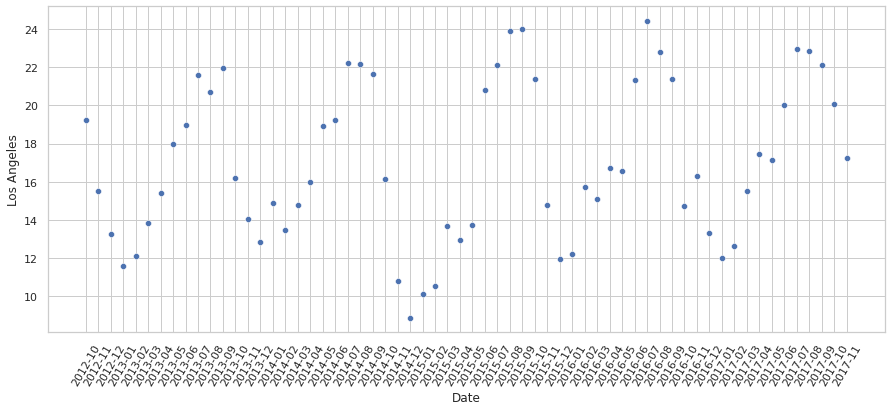

In [205]:
d = sns.scatterplot(x="Date", y="Los Angeles", data=tyc)
d.set_xticklabels(labels=tyc["Date"], rotation=60);

<ipython-input-207-ecc4047b8662>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_xticklabels(labels=tyc["Date"], rotation=60);


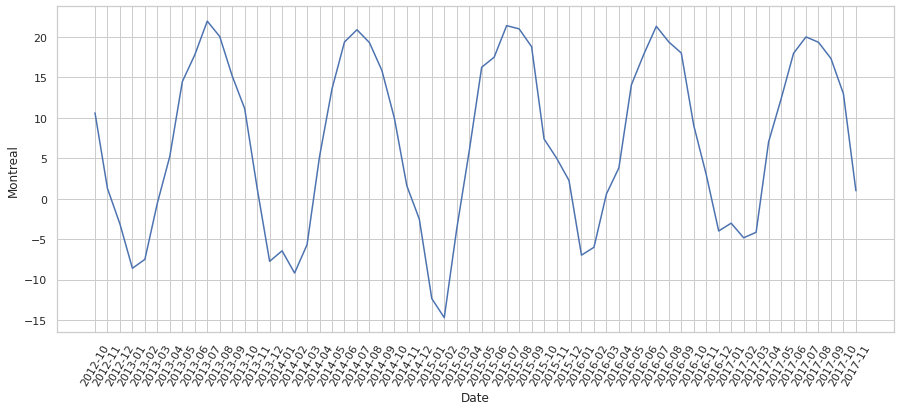

In [207]:
f = sns.lineplot(data=tyc, x="Date", y="Montreal")
f.set_xticklabels(labels=tyc["Date"], rotation=60);

<ipython-input-218-59a2bea7dc46>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels=tyc["Date"], rotation=60);


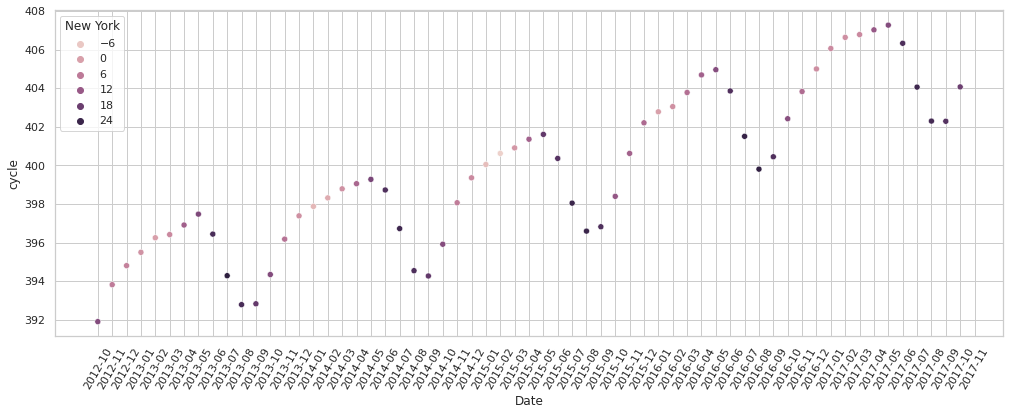

In [218]:
g = sns.scatterplot(x="Date", y="cycle", hue="New York", data=tyc)
g.set_xticklabels(labels=tyc["Date"], rotation=60);

<ipython-input-220-154051f8d62f>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels=hyc["Date"], rotation=60);


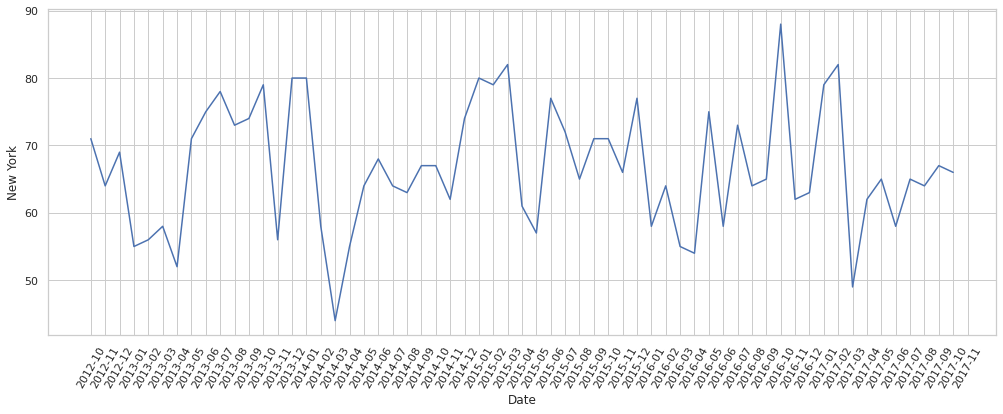

In [220]:
g = sns.lineplot(x="Date", y="New York", data=hyc)
g.set_xticklabels(labels=hyc["Date"], rotation=60);

<ipython-input-216-d8e7eab17242>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_xticklabels(labels=co2["Date"], rotation=75);


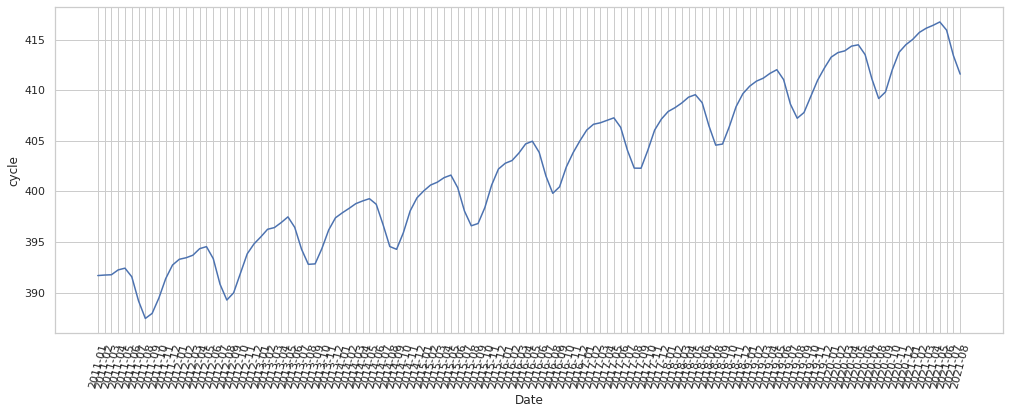

In [216]:
f = sns.lineplot(data=co2, x="Date", y="cycle")
f.set_xticklabels(labels=co2["Date"], rotation=75);

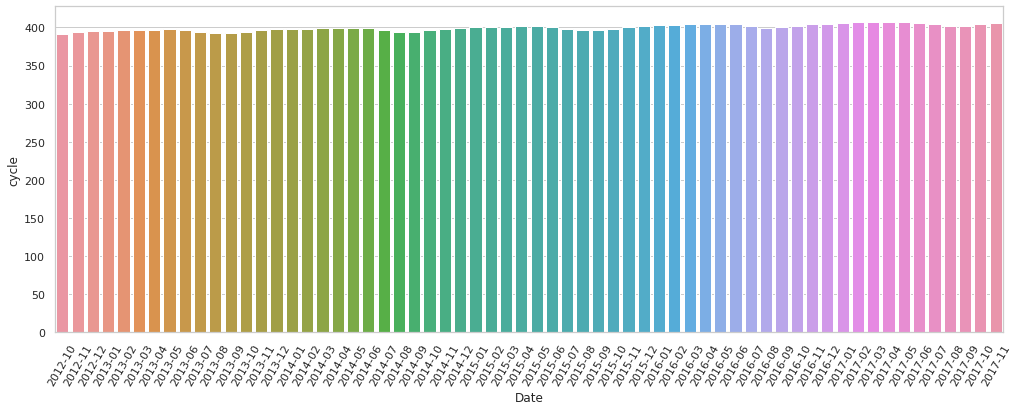

In [215]:
sns.barplot(x="Date", y="cycle", data=tyc).set_xticklabels(labels=tyc["Date"], rotation=60);